<a href="https://colab.research.google.com/github/YenaChoi00/ML-Final-Project/blob/main/ResNet18/CIFAR10_ResNet_Tensorboard_changelr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Final Project***
---

In this project, you will develop a convolutional neural network (CNN) to perform classification, and test it out on the CIFAR-10 dataset.


The given code is a simple implement for the CIFAR-10 classification. 

The goal of the final project is to check whether you understand important concepts for training CNN such as:

*   Network architecture
*   Optimization
*   Loss function
*   Data preprocessing
*   Regularization
*   ...

Therefore, you can **modify the given code to improve the performance** of the network **except for the dataset (i.e. trainset and testset)**.

You should **upload your code and your report** including an explaination of your code and what you have changed or added.

In [14]:
# AS usual, a bit of setup
# If you need other libraries, you should import the libraries.

import os, sys
import torch
from torch import nn
from torch.nn import functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
import numpy as np

In [15]:
# tensor board
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('./logs/adjustLR')

In [16]:
# Set the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# **Data Loader**

You can load the CIFAR-10 dataset using the library `torchvision.datasets`

The details of CIFAR-10 dataset can be found in https://www.cs.toronto.edu/~kriz/cifar.html

`transforms_cifar10` is used to assemble several transforms for data preprossing.

In [17]:
transforms_cifar10 = transforms.Compose([transforms.Resize((32, 32)),
                                  transforms.ToTensor(),
                                  transforms.RandomRotation(30),
                                  transforms.RandomHorizontalFlip(),
                                  transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                 ])

# Train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms_cifar10)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

# Test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms_cifar10)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# Classes of CIFAR-10 dataset
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


truck horse  frog  deer


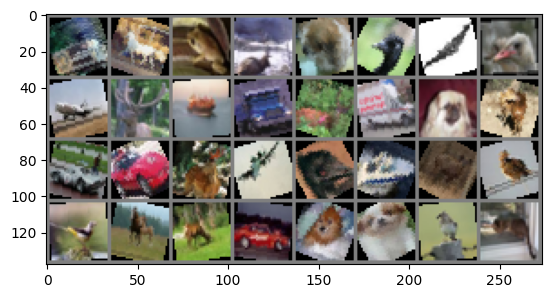

In [18]:
# Examples of dataset

def imshow(img):
  img = img /2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(trainloader)
imgs, labels = next(dataiter)

imshow(torchvision.utils.make_grid(imgs))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

# **Your own CNN**

You can implement your own network using libraries such as `torch.nn`and `torch.nn.functional`.

`SimpleNet` and `VGG11` are examples to help your understand the implementation of the network.

So, you can modify the given codes or create another awesome neural network for CIFAR-10 classification.

In [19]:
# ResNet
import torch.backends.cudnn as cudnn
import torch.optim as optim

# ResNet18을 위해 최대한 간단히 수정한 BasicBlock 클래스 정의
class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        # 3x3 필터를 사용 (너비와 높이를 줄일 때는 stride 값 조절)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        # 3x3 필터를 사용 (패딩을 1만큼 주기 때문에 너비와 높이가 동일)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) # 배치 정규화(batch normalization)

        self.shortcut = nn.Sequential() # identity인 경우
        if stride != 1: # stride가 1이 아니라면, Identity mapping이 아닌 경우
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) # (핵심) skip connection
        out = F.relu(out)
        return out


# ResNet 클래스 정의
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):    # 클래스 갯수를 1000으로 바꾸고, ImageNet도 학습 시킬 수 있음
        super(ResNet, self).__init__()
        self.in_planes = 64  #입력 채널 수

        # 64개의 3x3 필터(filter)를 사용
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1) # 총 4개의 conv layer를 가지고 있다.
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1) # 첫 번째 컨볼루션 레이어에 의해서만 너비와 높이가 줄어들 수 있게 함. 그 이후부터는 같은 너비와 높이 적용
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes # 다음 레이어를 위해 채널 수 변경
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        # 각 레이어를 순차적으로 지나고
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # average pooling 을 거치고
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        # fc layer까지 거쳐서,
        out = self.linear(out)
        return out


# ResNet18 함수 정의
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

net = ResNet18().to(device)

# **Loss function and optimizer**

Set the **loss function and optimizer** for training CNN.
You can modify the loss function or optimizer for better performance.

In [20]:
# Loss function and optimizer
#loss_fun = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

#net = torch.nn.DataParallel(net)
cudnn.benchmark = True

learning_rate = 0.01   # 0.1부터 시작하여 단계적으로 0.01 -> 0.001 -> ... 줄여간다.
file_name = 'resnet18_cifar10.pt'

loss_fun = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
#optimizer = optim.RMSprop(net.parameters(), lr=learning_rate)

def train(epoch):           
    print('\n[ Train epoch: %d ]' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        
        loss = loss_fun(outputs, targets)
        loss.backward()
        optimizer.step()    # 모델 파라미터 update

        train_loss += loss.item()
        _, predicted = outputs.max(1)

        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    
        if batch_idx % 100 == 0:
          print('\nCurrent batch:', str(batch_idx))
          print('Current benign train accuracy:', str(predicted.eq(targets).sum().item() / targets.size(0)))
          print('Current benign train loss:', loss.item())
        
    # tensorboard: train_loss 기록
    writer.add_scalar('Loss/train', train_loss / (batch_idx+1), epoch)
    # Calculate train_accuracy
    train_accuracy = 100. * correct / total
    # train_accuracy 기록
    writer.add_scalar('Accuracy/train', train_accuracy, epoch)
    
    print('\nTotal benign train accuracy:', 100. * correct / total)
    print('Total benign train loss:', train_loss / (batch_idx+1))


def test(epoch):
    print('\n[ Test epoch: %d ]' % epoch)
    net.eval()
    loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        total += targets.size(0)

        outputs = net(inputs)
        loss += loss_fun(outputs, targets).item()

        _, predicted = outputs.max(1)
        correct += predicted.eq(targets).sum().item()        

    print('\nTest accuarcy:', 100. * correct / total)
    print('Test average loss:', loss / total)

    # test_accuracy 기록
    test_accuracy = 100. * correct / total
    writer.add_scalar('Accuracy/test', test_accuracy, epoch)

    #state = {
    #    'net': net.state_dict()
    #}
    #if not os.path.isdir('checkpoint'):
    #    os.mkdir('checkpoint')
    #torch.save(state, './checkpoint/' + file_name)
    #print('Model Saved!')


def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 20:  # 200epoch일 때 절반정도의 타이밍에 줄임
        lr /= 10
    if epoch >= 40:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# **Train the network**

Train your own network using the above loss function and optimizer.

ResNet ver.

In [ ]:
for epoch in range(0, 60):
    adjust_learning_rate(optimizer, epoch)
    train(epoch)
    #test(epoch)


[ Train epoch: 0 ]

Current batch: 0
Current benign train accuracy: 0.09375
Current benign train loss: 2.4240996837615967

Current batch: 100
Current benign train accuracy: 0.375
Current benign train loss: 2.0291218757629395

Current batch: 200
Current benign train accuracy: 0.15625
Current benign train loss: 2.06510853767395

Current batch: 300
Current benign train accuracy: 0.28125
Current benign train loss: 1.9569778442382812

Current batch: 400
Current benign train accuracy: 0.28125
Current benign train loss: 2.054220676422119

Current batch: 500
Current benign train accuracy: 0.15625
Current benign train loss: 2.067070960998535

Current batch: 600
Current benign train accuracy: 0.5625
Current benign train loss: 1.430038332939148

Current batch: 700
Current benign train accuracy: 0.28125
Current benign train loss: 1.782387375831604

Current batch: 800
Current benign train accuracy: 0.4375
Current benign train loss: 1.553639531135559

Current batch: 900
Current benign train accurac

In [ ]:
writer.close()

# **Test the network**

Test the trained network using the testset.

Accuracy of the network on the 10,000 test images is the final accuracy of your network. 

The closer the accuray is to 100%, the better the network classifies the input image.

In [1]:
# Test the trained model with sample

dataiter_test = iter(testloader)
img_test, labels_test = next(dataiter_test)

imshow(torchvision.utils.make_grid(img_test))
print('GroundTruth: ', ' '.join('%5s' % classes[labels_test[j]] for j in range(4)))

img_test = img_test.to(device)
labels_test = labels_test.to(device)

# Prediction
outputs_test = net(img_test)
_, predicted = torch.max(outputs_test.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

NameError: ignored

In [ ]:
# Test the trained model with overall test dataset

correct = 0
total = 0
for data in testloader:
    # Load the data
    inputs_test, labels_test = data
    inputs_test = inputs_test.to(device)
    labels_test = labels_test.to(device)

    # Estimate the output using the trained network
    outputs_test = net(inputs_test)
    _, predicted = torch.max(outputs_test.data, 1)
    
    # Calculate the accuracy
    total += labels_test.size(0)
    correct += (predicted == labels_test).sum()

# test_accuracy 기록
test_accuracy = 100. * correct / total
writer.add_scalar('Accuracy/test', test_accuracy, epoch)

# Final accuracy
print('Accuracy of the network on the 10,000 test images: %d %%' % (100 * correct / total))


## [SimpleNet / Training 5 epochs] Accuracy of the network on the 10,000 test images: 9 %
## [VGG11 / Training 5 epochs] Accuracy of the network on the 10,000 test images: 11 %

In [ ]:
%ls

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=/content/logs